In [2]:
import pandas as pd
import sys
import os
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, power_transform
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier
from scipy import stats

In [166]:
os.chdir(r'\Users\gandh\OneDrive\Documents\ALY - Capstone\Startup Analysis')

# Defining the Dataset and Pre-processing

In [3]:
df_sc = pd.read_csv(r'C:\Users\gandh\OneDrive\Documents\ALY - Capstone\Startup Analysis\final_data_companies_social_media.csv')
df_sc = df_sc[df_sc.stage.notna() 
     & df_sc.name.notna() & df_sc["size_numeric"].notna()]
df_sc['market'] = df_sc['market'].apply(lambda row: str(row).replace(" ", "_"))

In [4]:
df_sc.shape

(2446, 18)

In [5]:
df_sc = df_sc.drop(columns = ['joined', 'kind', 'link', 'name', 'size', 'website', 'raised'])

# Exploratory Analysis

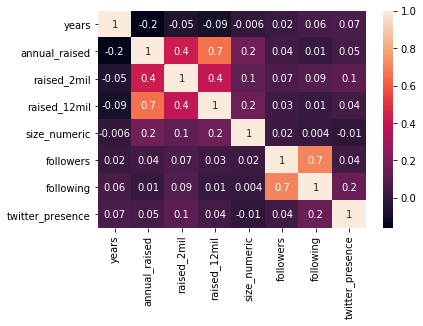

In [107]:
corrMatrix = df_sc.corr()
sn.heatmap(corrMatrix, annot = True, fmt='.1g')
plt.show()

### Defining Data with Social Media Parameters

In [6]:
#seed data
seed_df = df_sc[(df_sc["stage"]=="Seed")]
seed_y = seed_df['raised_2mil']

In [7]:
print(seed_df.shape)
print(seed_y.shape)

(1912, 11)
(1912,)


In [8]:
#series A data
seriesA_df = df_sc[(df_sc["stage"]=="Series A")]
seriesA_y_df = seriesA_df['raised_12mil']

In [9]:
print(seriesA_df.shape)
print(seriesA_y_df.shape)

(534, 11)
(534,)


### Defining Data without Social Media Parameters

In [10]:
seed_nosocial = df_sc.drop(columns = ['followers', 'following', 'twitter_presence'])
seed_nosocial = seed_nosocial[seed_nosocial["stage"]=="Seed"]
seed_nosocial_y = seed_nosocial['raised_2mil']

In [11]:
print(seed_nosocial.shape)
print(seed_nosocial_y.shape)

(1912, 8)
(1912,)


In [12]:
seriesA_nosocial = df_sc.drop(columns = ['followers', 'following', 'twitter_presence'])
seriesA_nosocial = seriesA_nosocial[seriesA_nosocial["stage"]=="Series A"]
seriesA_nosocial_y = seriesA_nosocial['raised_12mil']

In [13]:
print(seriesA_nosocial.shape)
print(seriesA_nosocial_y.shape)

(534, 8)
(534,)


## One Hot Encoding

In [14]:
def one_hot(dataframe, nominal):
    gen_onehot_features = pd.get_dummies(dataframe[nominal])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop([nominal],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result

In [15]:
#one hot encoded data of 'seed' with social media presence
seed_ohc =one_hot(one_hot(seed_df[['location','size_numeric','years','market','followers','following','twitter_presence']],"location"),"market")
print(seed_ohc.shape)

(1912, 86)


In [16]:
#one hot encoded data fit
seed_all_ohc_data = seed_ohc
seed_all_ohc_data['raised_2m'] = seed_y.to_frame()

In [17]:
#one hot encoded data of 'series A' with social media presence
seriesA_ohc =one_hot(one_hot(seriesA_df[['location','size_numeric','years','market','followers','following','twitter_presence']],"location"),"market")
print(seriesA_ohc.shape)

(534, 99)


In [18]:
#one hot encoded data fit
seriesA_all_ohc_data = seriesA_ohc
seriesA_all_ohc_data['raised_2m'] = seriesA_y_df.to_frame()

In [19]:
#one hot encoded data of 'seed' without social media presence
seed_ns_ohc =one_hot(one_hot(seed_nosocial[['location','size_numeric','years','market']],"location"),"market")
print(seed_ns_ohc.shape)

(1912, 83)


In [20]:
seed_nosocial_ohc = seed_ns_ohc
seed_nosocial_ohc['raised_2m'] = seed_nosocial_y.to_frame()

In [21]:
seriesA_ns_ohc =one_hot(one_hot(seriesA_nosocial[['location','size_numeric','years','market']],"location"),"market")
print(seriesA_ns_ohc.shape)

(534, 96)


In [22]:
seriesA_nosocial_ohc = seriesA_ns_ohc
seriesA_nosocial_ohc['raised_2m'] = seriesA_nosocial_y.to_frame()

# XGBoost

## With Social Media Influence

In [29]:
social_x = seed_ohc.drop(columns = ['raised_2m'])
social_y = seed_y
for i in [social_x, social_y]:
    print(i.shape)

social_x.head(5)

(1912, 86)
(1912,)


,size_numeric,years,followers,following,twitter_presence,Amsterdam,Atlanta,Austin,Bengaluru,Berlin,...,Productivity_Software,Retail_Technology,SaaS,Small_and_Medium_Businesses,Social_Media,Social_Media_Platforms,Technology,Training,Video_Streaming,nan
0,5.0,7.627397,57,74,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,25.0,5.375342,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,25.0,6.290411,2657,3032,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25.0,3.871233,1244,916,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,5.0,7.290411,327,1200,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(social_x, social_y, test_size=0.2, random_state = 3)
for i in [X_train, X_test, y_train, y_test]:
    print(i.shape)
    
X_train.head(5)

(1529, 86)
(383, 86)
(1529,)
(383,)


,size_numeric,years,followers,following,twitter_presence,Amsterdam,Atlanta,Austin,Bengaluru,Berlin,...,Productivity_Software,Retail_Technology,SaaS,Small_and_Medium_Businesses,Social_Media,Social_Media_Platforms,Technology,Training,Video_Streaming,nan
1393,5.0,6.709589,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
515,5.0,7.709589,671,1133,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2045,25.0,4.208219,18000,9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024,25.0,7.290411,6730,4716,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019,25.0,5.460274,197,51,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


size_numeric             0.093897
Mobile_Games             0.044401
San Jose                 0.040849
Mobile_Payments          0.030916
San Francisco            0.026430
Crowdsourcing            0.020938
Productivity_Software    0.019618
Delhi                    0.019412
Human_Resources          0.019270
Fantasy_Sports           0.019211
dtype: float32
Accuracy of the GBM on test set: 0.755
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       316
           1       0.33      0.40      0.36        67

    accuracy                           0.75       383
   macro avg       0.60      0.62      0.61       383
weighted avg       0.77      0.75      0.76       383

[[262  54]
 [ 40  27]]


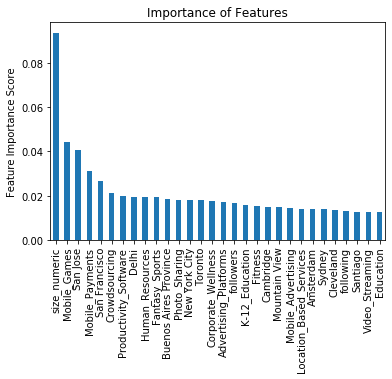

In [42]:
baselinexgb = XGBClassifier(learning_rate=0.1, 
                            n_estimators=1250, max_depth=3, 
                            subsample=1, scale_pos_weight = 5,
                            random_state=10)
baselinexgb.fit(X_train,y_train)
predictors=list(X_train)

feat_imp = pd.Series(baselinexgb.feature_importances_, predictors).sort_values(ascending=False)
print(feat_imp.head(10))
feat_imp.head(30).plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baselinexgb.score(X_test, y_test)))
pred=baselinexgb.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

In [28]:
feature_testx1 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
                 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator =XGBClassifier(scale_pos_weight = 5, random_state=10), 
            param_grid = feature_testx1, scoring='accuracy',n_jobs=4,iid=False, cv=5)

tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

## Results: learning Rate = 0.05, n-Estimators = 1750

C:\Users\gandh\anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 1.29336872,  3.61616354,  6.38894286,  8.8141717 ,  9.63364348,
         11.6783824 , 14.18819003, 16.44365487,  0.98587608,  2.61576676,
          4.88959341,  7.19853778,  9.68687439, 11.97010026, 14.29951892,
         16.82391248,  0.96245227,  2.4271522 ,  4.88919663,  7.08856974,
          9.712183  , 13.06585383, 14.9090971 , 16.78119092,  1.00892358,
          2.49818697,  4.80462246,  7.22853451, 10.0243505 , 12.29387121,
         14.25478234, 16.61971893,  0.97941632,  2.65834136,  5.35362678,
          7.14505801,  9.59465036, 11.98647876, 14.38054438, 17.14949617,
          0.96324525,  2.53296723,  5.10727339,  7.33568745,  9.72205505,
         12.41082621, 14.88010464, 15.11916599]),
  'std_fit_time': array([0.17903629, 0.20164445, 0.24985014, 0.61975297, 0.30414143,
         0.25330751, 0.18610379, 0.25391614, 0.12727503, 0.11023043,
         0.13339464, 0.15038228, 0.09753224, 0.11945896, 0.43964859,
         0.44681907, 0.03629217, 0.08084703,

In [31]:
feature_testx2 = {'max_depth':[2,3,4,5,6,7],
                 'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}

tuning = GridSearchCV(estimator =XGBClassifier(learning_rate = 0.05, n_estimators = 1750,
                                               scale_pos_weight = 5, random_state=10), 
            param_grid = feature_testx2, scoring='accuracy',n_jobs=4,iid=False, cv=5)

tuning.fit(X_train,y_train)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

## Results: Max Depth = 5, Subsample = 0.8

C:\Users\gandh\anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 8.51746583,  8.33717294,  7.26187639,  6.58484068,  6.63118095,
          6.47884774,  6.83032289,  9.09904251,  9.14416375,  9.26423459,
          9.19703007,  9.30617237,  9.9567759 ,  8.78233986, 11.23629904,
         11.46845069, 11.85624614, 11.96959386, 12.62863255, 11.69487829,
         11.60227294, 14.94109154, 15.7126121 , 14.19387197, 14.65328469,
         14.66952868, 14.36130238, 14.13791223, 16.88863869, 16.38340001,
         16.55220232, 17.06889172, 21.85721779, 22.72819314, 21.73025618,
         26.04847312, 26.73929734, 23.79579296, 23.87335243, 26.1646255 ,
         30.24872861, 26.4732955 ]),
  'std_fit_time': array([0.50685211, 0.92797702, 0.24521117, 0.11512637, 0.13120273,
         0.08021743, 0.43959109, 0.39509363, 0.18801462, 0.21841528,
         0.19293691, 0.12533723, 0.41386261, 0.09797164, 0.22228228,
         0.0543704 , 0.41351952, 0.4348093 , 0.52597747, 0.10342215,
         0.16928091, 0.62775466, 0.76076562, 0.31110734, 0.243

Mobile_Games                          0.034603
Health_Care_Information_Technology    0.031855
size_numeric                          0.025578
Tel Aviv-Yafo                         0.023216
Delhi                                 0.022746
Cambridge                             0.022336
Mobile_Payments                       0.021134
Santa Monica                          0.020510
Crowdsourcing                         0.019617
Human_Resources                       0.019103
dtype: float32
Accuracy of the GBM on test set: 0.775
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       316
           1       0.34      0.31      0.33        67

    accuracy                           0.78       383
   macro avg       0.60      0.59      0.60       383
weighted avg       0.77      0.78      0.77       383

[[276  40]
 [ 46  21]]
True Positive Rate : 0.873
True Negative Rate : 0.313


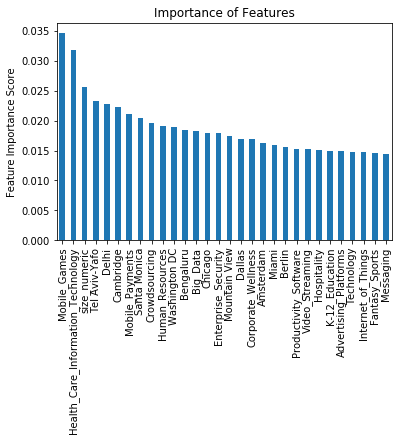

In [31]:
finalxgb = XGBClassifier(learning_rate=0.05, 
                            n_estimators=1750, max_depth=5, 
                            subsample=0.8, scale_pos_weight = 5,
                            random_state=10)

finalxgb.fit(X_train,y_train)
predictors=list(X_train)

feat_imp = pd.Series(finalxgb.feature_importances_, predictors).sort_values(ascending=False)

print(feat_imp.head(10))

feat_imp.head(30).plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

print('Accuracy of the GBM on test set: {:.3f}'.format(finalxgb.score(X_test, y_test)))

pred=finalxgb.predict(X_test)

print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
print(cm)

acc = np.round(finalxgb.score(X_test, y_test), 3)
tpr = np.round(cm[0][0]/np.sum(cm[0]), 3)
tnr = np.round(cm[1][1]/np.sum(cm[1]), 3)
print('True Positive Rate :' ,tpr)
print('True Negative Rate :' ,tnr)

## Without Social Media Influence

In [36]:
nosocial_x = seed_ns_ohc.drop(columns = 'raised_2m')
nosocial_y = seed_nosocial_y
for i in [nosocial_x, nosocial_y]:
    print(i.shape)

(1912, 83)
(1912,)


In [37]:
xTrain, xTest, yTrain, yTest = train_test_split(nosocial_x, nosocial_y, test_size=0.2, random_state = 3)
for i in [xTrain, xTest, yTrain, yTest]:
    print(i.shape)

(1529, 83)
(383, 83)
(1529,)
(383,)


size_numeric             0.066663
Mobile_Games             0.051883
Fantasy_Sports           0.026832
San Francisco            0.025380
Mobile_Payments          0.024917
Corporate_Wellness       0.024285
Crowdsourcing            0.023049
Delhi                    0.021579
Buenos Aires Province    0.019612
Cleveland                0.019396
dtype: float32
Accuracy of the GBM on test set: 0.744
              precision    recall  f1-score   support

           0       0.89      0.78      0.84       316
           1       0.35      0.55      0.43        67

    accuracy                           0.74       383
   macro avg       0.62      0.67      0.63       383
weighted avg       0.80      0.74      0.76       383

[[248  68]
 [ 30  37]]


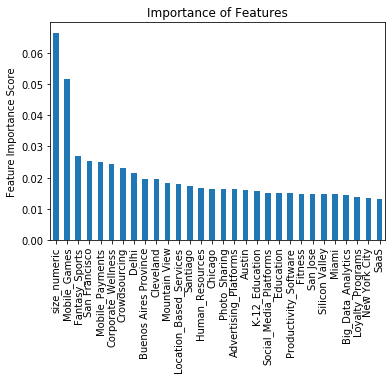

In [157]:
baselinexgb_ns = XGBClassifier(learning_rate=0.1, 
                            n_estimators=1250, max_depth=3, 
                            subsample=1, scale_pos_weight = 5,
                            random_state=10)
baselinexgb_ns.fit(xTrain, yTrain)
predictors=list(xTrain)

feat_imp = pd.Series(baselinexgb_ns.feature_importances_, predictors).sort_values(ascending=False)
print(feat_imp.head(10))
feat_imp.head(30).plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baselinexgb_ns.score(xTest, yTest)))
pred=baselinexgb_ns.predict(xTest)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

In [52]:
yTest.unique()

array([0, 1], dtype=int64)

In [53]:
feature_test_ns1 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 
                 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator =XGBClassifier(scale_pos_weight = 5, random_state=10), 
            param_grid = feature_test_ns1, scoring='accuracy',n_jobs=4,iid=False, cv=5)

tuning.fit(xTrain, yTrain)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

## Results: learning Rate = 0.05, n-Estimators = 100

C:\Users\gandh\anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([ 0.81585474,  2.62242494,  6.37264085, 11.94185376, 12.84153018,
         14.365377  , 16.36255445, 19.43174434,  1.12107692,  2.814358  ,
          5.97299314,  9.35261221, 11.76480803, 14.88508062, 18.07711148,
         26.2867641 ,  1.83671236,  4.01589012,  7.54076018, 11.12053742,
         14.30585294, 17.44637642, 22.18393593, 26.6970993 ,  1.76560087,
          4.27255797,  7.96185818, 11.44065242, 16.19903188, 19.30934215,
         22.04270792, 25.26844659,  1.5233582 ,  3.51665125,  7.24400077,
         10.60510464, 15.63921566, 18.75491304, 22.49693565, 26.07457905,
          1.54557829,  3.84710789,  8.21904225, 12.4837131 , 16.28305998,
         19.24242845, 21.85411267, 24.1947691 ]),
  'std_fit_time': array([0.18080068, 0.40072032, 0.98821618, 1.515095  , 0.5723534 ,
         0.32817045, 0.23754678, 0.446271  , 0.01380443, 0.1492688 ,
         0.35723366, 0.46261625, 0.47764535, 0.94034711, 2.46236123,
         1.2458354 , 0.42120183, 0.48223774,

In [54]:
feature_test_ns2 = {'max_depth':[2,3,4,5,6,7],
                 'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}

tuning = GridSearchCV(estimator =XGBClassifier(learning_rate = 0.05, n_estimators = 100,
                                               scale_pos_weight = 5, random_state=10), 
            param_grid = feature_test_ns2, scoring='accuracy',n_jobs=4,iid=False, cv=5)

tuning.fit(xTrain, yTrain)
tuning.cv_results_, tuning.best_params_, tuning.best_score_

## Results: Max Depth = 7, Subsample = 0.75

C:\Users\gandh\anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'mean_fit_time': array([0.41839361, 0.44842601, 0.55214429, 0.5394845 , 0.36915641,
         0.47837639, 0.37617373, 0.73438787, 0.72782459, 0.64221735,
         0.83054085, 0.85280409, 0.60398307, 0.53165641, 0.72977719,
         0.74355931, 0.72442999, 0.68759446, 0.75347514, 0.72280636,
         0.66098814, 0.86994882, 1.04695034, 1.20180426, 1.08539939,
         1.31524053, 1.3636157 , 1.1774004 , 1.33696527, 1.33950186,
         1.43036666, 1.42815681, 1.33446898, 1.53495531, 1.49153237,
         1.81931148, 1.71112709, 1.64415736, 1.60220275, 1.83334341,
         1.91785746, 2.07918634]),
  'std_fit_time': array([0.03554082, 0.09993816, 0.11410627, 0.08383531, 0.0340659 ,
         0.07953267, 0.05573273, 0.0684617 , 0.08017751, 0.10114252,
         0.17736676, 0.24207319, 0.04656202, 0.06916357, 0.08122803,
         0.07106613, 0.11020065, 0.0512787 , 0.07178897, 0.09503594,
         0.04930268, 0.12448669, 0.12192101, 0.05383727, 0.07509215,
         0.25961989, 0.2248224 , 0.

size_numeric           0.089374
Las Vegas              0.023125
San Francisco          0.022259
Mobile_Payments        0.019201
Enterprise_Security    0.018616
Cambridge              0.018099
Mobile_Games           0.018051
Big_Data               0.017720
Washington DC          0.016383
Developer_APIs         0.015875
dtype: float32
Accuracy of the GBM on test set: 0.744
              precision    recall  f1-score   support

           0       0.92      0.76      0.83       316
           1       0.37      0.67      0.48        67

    accuracy                           0.74       383
   macro avg       0.64      0.72      0.65       383
weighted avg       0.82      0.74      0.77       383

[[240  76]
 [ 22  45]]
True Positive Rate : 0.759
True Negative Rate : 0.672


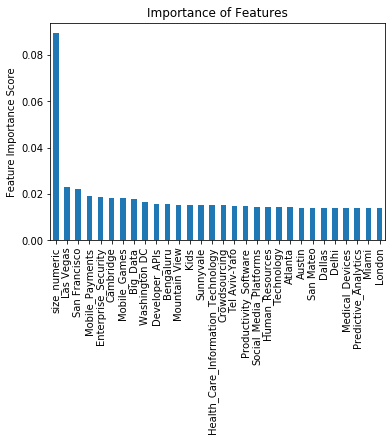

In [39]:
finalxgb_ns = XGBClassifier(learning_rate=0.05, 
                            n_estimators=100, max_depth=7, 
                            subsample=0.75, scale_pos_weight = 5,
                            random_state=10)

finalxgb_ns.fit(xTrain, yTrain)
predictors=list(xTrain)

feat_imp = pd.Series(finalxgb_ns.feature_importances_, predictors).sort_values(ascending=False)

print(feat_imp.head(10))

feat_imp.head(30).plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

print('Accuracy of the GBM on test set: {:.3f}'.format(finalxgb_ns.score(xTest, yTest)))

pred=finalxgb_ns.predict(xTest)

print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
print(cm)
acc_ns = np.round(finalxgb_ns.score(xTest, yTest), 3)
tpr_ns = np.round(cm[0][0]/np.sum(cm[0]), 3)
tnr_ns = np.round(cm[1][1]/np.sum(cm[1]), 3)
print('True Positive Rate :' ,tpr_ns)
print('True Negative Rate :' ,tnr_ns)

## Final Results for Seed Model

In [40]:
final_data = [['XGB Seed with Social Media', acc, tpr, tnr], 
              ['XGB Seed without Social Media', acc_ns, tpr_ns, tnr_ns]]
df = pd.DataFrame(final_data, columns = ['Method', 'Test Accuracy', 'TPR', 'TNR'])
df

,Method,Test Accuracy,TPR,TNR
0,XGB Seed with Social Media,0.775,0.873,0.313
1,XGB Seed without Social Media,0.744,0.759,0.672


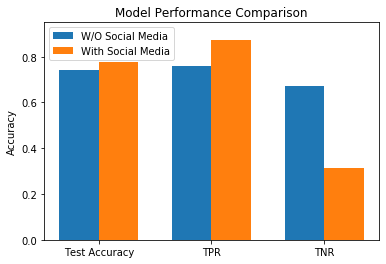

In [41]:
N = 3
width = 0.35 
pos = np.arange(N)

plt.bar(pos,df[['Test Accuracy','TPR','TNR']].iloc[1],width, label = 'W/O Social Media')
plt.bar([p + width for p in pos],df[['Test Accuracy','TPR','TNR']].iloc[0],width, label='With Social Media')

plt.ylabel('Accuracy')
plt.ylim([0, 0.95])

plt.xticks(pos + width / 2, ('Test Accuracy','TPR','TNR'))
plt.legend(loc='best')
plt.title("Model Performance Comparison")
plt.show()